In [24]:
import itertools
import os
from pathlib import Path
import pandas as pd 

import matplotlib
matplotlib.use("agg")    # must select backend before importing pyplot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# D-Wave Ocean tools
import dimod
from dwave.system import DWaveCliqueSampler
from tabu import TabuSampler

import saspy

# Quantifying Information: Shannon Entropy
### Shannon entropy, mathematically quantifies the information in a signal:

The Shannon Entropy (SE) formula can be understood as weighing by an event's probability for the event, where the reciprocal is due to the minus sign. This value means that the less likely the occurrence of an event, the more information is attributed to it (intuitively, when a man bites a dog it's news).

To calculate SE, the prob function defined below calculates probability for a dataset representing some variables (a training set in a machine learning context) by dividing it into bins as a histogram using the NumPy library's histogramdd function.

In [25]:
# Define MI calculations
def prob(dataset):
    """Joint probability distribution P(X) for the given data."""

    # bin by the number of different values per feature
    num_rows, num_columns = dataset.shape
    bins = [len(np.unique(dataset[:, ci])) for ci in range(num_columns)]

    prob, _ = np.histogramdd(dataset, bins)
    return prob / np.sum(prob)


In [26]:

def shannon_entropy(p):
    """Shannon entropy H(X) is the negative sum of P(X)log(P(X)) for probability
    distribution P(X).
    """
    p = p.flatten()
    return -sum(pi*np.log2(pi) for pi in p if pi)

# Conditional Shannon Entropy
### Conditional SE (CSE) measures the information in one signal,  𝑋 , when the value of another signal,  𝑌 , is known:

Measures the information in both signals together, with  𝑝(𝑥,𝑦)  being their joint probability. For example, knowing that it's winter reduces the information value of news that it is raining.

In [27]:
def conditional_shannon_entropy(p, *conditional_indices):
    """Conditional Shannon entropy H(X|Y) = H(X,Y) - H(Y)."""

    # Sanity check on validity of conditional_indices.  In particular,
    # try to trap issues in which dimensions have been removed from
    # probability table through marginalization, but
    # conditional_indices were not updated accordingly.
    assert(all(ci < p.ndim for ci in conditional_indices))

    axis = tuple(i for i in np.arange(len(p.shape))
                 if i not in conditional_indices)

    return shannon_entropy(p) - shannon_entropy(np.sum(p, axis=axis))

# Mutual Information
### Mutual information between variables  𝑋  and  𝑌  is defined as

𝑝(𝑥)  and  𝑝(𝑦)  are marginal probabilities of  𝑋  and  𝑌 , and  𝑝(𝑥,𝑦)  the joint probability.

Mutual information (MI) quantifies how much one knows about one random variable from observations of another. Intuitively, a model based on just one of a pair of features (e.g., farmer MacDonald's water rations and soil humidity) will better reproduce their combined contribution when MI between them is high.

In [28]:
def mutual_information(prob, j):
    """Mutual information between variables X and variable Y.

    Calculated as I(X; Y) = H(X) - H(X|Y)."""

    return (shannon_entropy(np.sum(prob, axis=j))
            - conditional_shannon_entropy(prob, j))

# Conditional Mutual Information
### Conditional mutual information (CMI) between a variable of interest,  𝑋 , and a feature,  𝑌 , given the selection of another feature,  𝑍.

Is the CSE of  𝑋  conditional on both  𝑌  and  𝑍 .

In this code cell, because marginalization over  𝑗  removes a dimension, any conditional indices pointing to subsequent dimensions are decremented by 1.

In [29]:
def conditional_mutual_information(p, j, *conditional_indices):
    """Mutual information between variables X and variable Y conditional on variable Z.

    Calculated as I(X;Y|Z) = H(X|Z) - H(X|Y,Z)"""

    # Compute an updated version of the conditional indices for use
    # when the probability table is marginalized over dimension j.
    # This marginalization removes one dimension, so any conditional
    # indices pointing to dimensions after this one must be adjusted
    # accordingly.
    marginal_conditional_indices = [i-1 if i > j else i for i in conditional_indices]

    return (conditional_shannon_entropy(np.sum(p, axis=j), *marginal_conditional_indices)
            - conditional_shannon_entropy(p, j, *conditional_indices))

In [30]:
def maximum_energy_delta(bqm):
    """Compute conservative bound on maximum change in energy when flipping a single variable"""
    return max(abs(bqm.get_linear(i))
               + sum(abs(bqm.get_quadratic(i,j))
                     for j, _ in bqm.iter_neighborhood(i))
               for i in bqm.variables)

In [31]:
def mutual_information_bqm(dataset, features, target):
    """Build a BQM that maximizes MI between survival and a subset of features"""
    variables = ((feature, -mutual_information(prob(dataset[[target, feature]].values), 1))
                 for feature in features)
    interactions = ((f0, f1, -conditional_mutual_information(prob(dataset[[target, f0, f1]].values), 1, 2))
                    for f0, f1 in itertools.permutations(features, 2))
    return dimod.BinaryQuadraticModel(variables, interactions, 0, dimod.BINARY)

In [32]:
def add_combination_penalty(bqm, k, penalty):
    """Create a new BQM with an additional penalty biased towards k-combinations"""
    kbqm = dimod.generators.combinations(bqm.variables, k, strength=penalty)
    kbqm.update(bqm)
    return kbqm

In [33]:
def mutual_information_feature_selection(dataset, features, target, num_reads=5000):
    """Run the MIFS algorithm on a QPU solver"""
    
    # Set up a QPU sampler that embeds to a fully-connected graph of all the variables
    sampler = DWaveCliqueSampler()
    #sampler = TabuSampler()
    
    # For each number of features, k, penalize selection of fewer or more features
    selected_features = np.zeros((len(features), len(features)))

    bqm = mutual_information_bqm(dataset, features, target)

    # This ensures that the soltion will satisfy the constraints.
    penalty = maximum_energy_delta(bqm)

    for k in range(1, len(features) + 1):
        print("Submitting for k={}".format(k))
        kbqm = add_combination_penalty(bqm, k, penalty)
        sample = sampler.sample(kbqm,
                                label='Example - MI Feature Selection',
                                num_reads=num_reads).first.sample
        for fi, f in enumerate(features):
            selected_features[k-1, fi] = sample[f]
    return selected_features

In [34]:
def run_demo(dataset, target):
    """Compute MIFS for each value of k and visualize results"""
    global df_1,df_2, keep
    # Rank the MI between survival and every other variable
    scores = {feature: mutual_information(prob(dataset[[target, feature]].values), 0)
              for feature in set(dataset.columns) - {target}}

    #labels, values = zip(*sorted(scores.items(), key=lambda pair: pair[1], reverse=True))

       # Plot the MI between survival and every other variable
    #plt.figure()
    #ax1 = plt.subplot(1, 2, 1)
    #ax1.set_title("Mutual Information")
    #ax1.set_ylabel('MI Between Survival and Feature')
    #plt.xticks(np.arange(len(labels)), labels, rotation=90)
    #plt.bar(np.arange(len(labels)), values)

    # The Titanic dataset provides a familiar, intuitive example available in the public
    # domain. In itself, however, it is not a good fit for solving by sampling. Run naively on
    # this dataset, it finds numerous good solutions but is unlikely to find the exact optimal solution.
    # There are many techniques for reformulating problems for the D-Wave system that can
    # improve performance on various metrics, some of which can help narrow down good solutions
    # to closer approach an optimal solution.
    # This demo solves the problem for just the highest-scoring features.

    # Select 8 features with the top MI ranking found above.
    keep = 8

    sorted_scores = sorted(scores.items(), key=lambda pair: pair[1], reverse=True)
    dataset = dataset[[column[0] for column in sorted_scores[0:keep]] + ["survived"]]
    features = sorted(list(set(dataset.columns) - {target}))
    selected_features = mutual_information_feature_selection(dataset, features, target)
    
       # Plot the best feature set per number of selected features
    #ax2 = plt.subplot(1, 2, 2)
    #ax2.set_title("Best Feature Selection")
    #ax2.set_ylabel('Number of Selected Features')
    #ax2.set_xticks(np.arange(len(features)))
    #ax2.set_xticklabels(features, rotation=90)
    #ax2.set_yticks(np.arange(len(features)))
    #ax2.set_yticklabels(np.arange(1, len(features)+1))
       # Set a grid on minor ticks
    #ax2.set_xticks(np.arange(-0.5, len(features)), minor=True)
    #ax2.set_yticks(np.arange(-0.5, len(features)), minor=True)
    #ax2.grid(which='minor', color='black')
    #ax2.imshow(selected_features, cmap=colors.ListedColormap(['white', 'red']))
 
    df_1 = pd.DataFrame(selected_features, columns=features)
    df_2 = pd.DataFrame(sorted_scores)
    #print(selected_features)
    #print(features)
    #print(dataset)
    #print(sorted_scores)
    return df_1, df_2

In [35]:
if __name__ == "__main__":
    # Read the feature-engineered data into a pandas dataframe
    # Data obtained from http://biostat.mc.vanderbilt.edu/DataSets
    demo_path = os.path.dirname(os.path.abspath("__file__"))
    data_path = os.path.join(demo_path, 'data', 'formatted_titanic.csv')
    dataset = pd.read_csv(data_path)
    run_demo(dataset, 'survived')
    #plots_path = os.path.join(demo_path, "plfeaturesots.png")
    #plt.savefig(plots_path, bbox_inches="tight")
    #print("Your plots are saved to {}".format(plots_path))
    print("Quantum Feature Detection Complete for {} Feature(s)".format(keep))

Submitting for k=1
Submitting for k=2
Submitting for k=3
Submitting for k=4
Submitting for k=5
Submitting for k=6
Submitting for k=7
Submitting for k=8
Quantum Feature Detection Complete for 8 Feature(s)


In [36]:
# Assign some column names
df_2.columns=['feature','mi']
#print(df_2)

# Post Process Quantum Output Using SAS

In [37]:
sas=saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 10081



In [38]:
# Convert the dataframes into SAS datasets
SF = sas.df2sd(df_1,'sel_features','work')  
MI = sas.df2sd(df_2, 'mi','work')


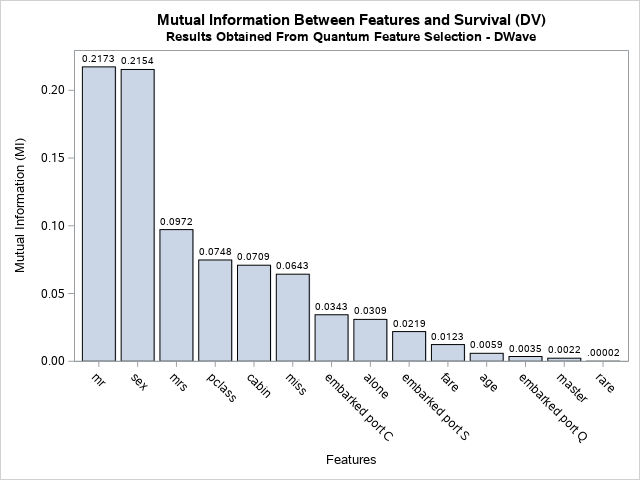

In [39]:
## Create scatterplot of Mutual Information Between Features and DV
code=sas.submitLST("""
proc sgplot data =  work.mi;
    	vbar feature / response= mi datalabel categoryorder=respdesc ;
        xaxis label='Features';
        yaxis label='Mutual Information (MI)';
        title1 'Mutual Information Between Features and Survival (DV)';
        title2 'Results Obtained From Quantum Feature Selection - DWave';
run;
""")


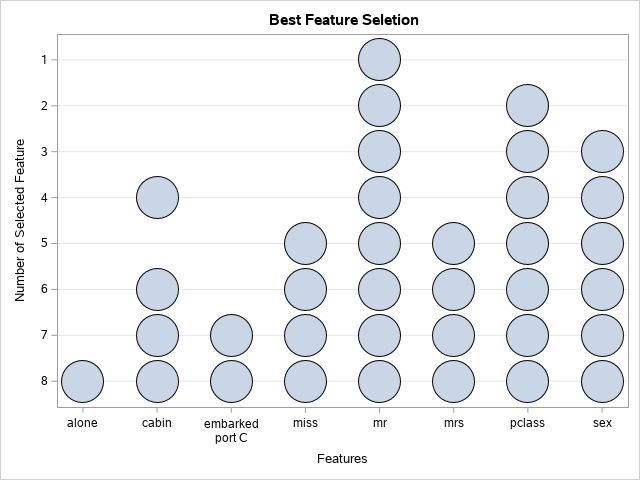

In [41]:
## Create Feature Number Variable and then Transpose the dataset by it
# Create PLot to show The number of selected features for each chosen feature
code=sas.submitLST("""
data work.sel_features;
    set work.sel_features;
    num_feat=_n_;
run;
proc transpose data = work.sel_features out=work.sel_tr (where=(_name_ ne 'num_feat'));
    by num_feat;
    var _numeric_;
run;
proc sgplot data = sel_tr ;
    bubble x= _name_  y=num_feat size=col1 / BRADIUSMIN=0;
    yaxis reverse values=(1 to 8 by 1) label='Number of Selected Feature' grid;
    xaxis label='Features';
    title 'Best Feature Seletion';
run;
""")


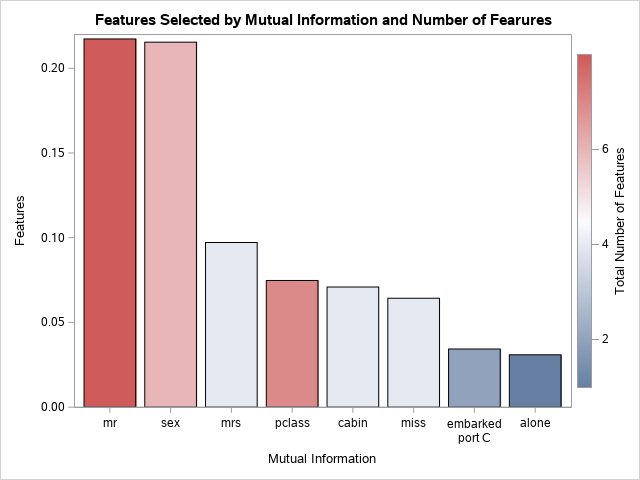
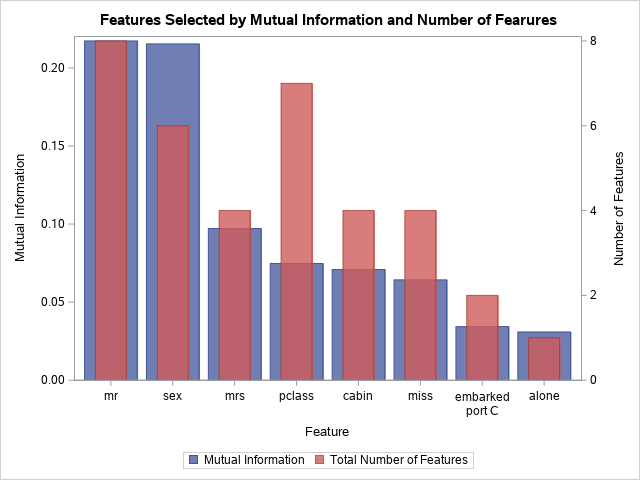

In [42]:
code=sas.submitLST("""

proc means data = sel_tr noprint nway;
    class _name_;
    output out=work.summ (drop=_type_ _freq_) sum(col1)=tot_features;
run;

proc sort data=work.mi; by feature;run;
proc sort data=work.summ; by _name_;run;

data work.combined;
    merge work.mi (in=a)
          work.summ (in=b rename=(_name_=feature));
    by feature;
    if a and b;
run;
proc sort data= work.combined;
    by descending mi;
run;

proc sgplot data = work.combined;
    vbar feature /  response=mi colorresponse=tot_features categoryorder=respdesc  ;
    gradlegend  / title="Total Number of Features" outterpad=(top=20 bottom=20);
    xaxis label = 'Mutual Information';
    yaxis label = 'Features';
    title 'Features Selected by Mutual Information and Number of Features';
run;

proc sgplot data = work.combined;
    vbar feature / response = mi  categoryorder=respdesc ;
    vbar feature / response = tot_features y2axis transparency=.2 barwidth=.5;
    yaxis label='Mutual Information';
    y2axis label='Number of Features';
    xaxis label='Feature';
    label   mi = 'Mutual Information'
            tot_features = 'Total Number of Features';
run;

proc print data = work.combined noobs label;
    id feature;
    var mi tot_features;
    label feature='Feature'
          mi = 'Mutual Information'
          tot_features = 'Total Number of Features';
          title;
run;
""")